**Importing libraries and loading dataset**

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap

# Loading dataset
df = pd.read_csv("customer_shopping_data.csv")

# Showing first rows
df.head()


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,05/08/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,09/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


**Data Cleaning**

In [2]:
# Removing duplicate rows
df = df.drop_duplicates()

# Handling missing values by filling or dropping
df = df.dropna(subset=['price', 'quantity'])
df['age'] = df['age'].fillna(df['age'].median())

# Converting invoice_date into datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')

# Creating target variable "total_sales"
df['total_sales'] = df['price'] * df['quantity']

df.head()


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,total_sales
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40


**Feature engineering**

In [3]:
# Extracting time features
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df['day'] = df['invoice_date'].dt.day
df['weekday'] = df['invoice_date'].dt.weekday

# Aggregating customer-level behavior
customer_avg_price = df.groupby('customer_id')['price'].mean().rename("customer_avg_price")
df = df.merge(customer_avg_price, on='customer_id', how='left')

# Creating encoded categorical and numeric lists
categorical_features = ['gender', 'category', 'payment_method', 'shopping_mall']
numeric_features = ['age', 'quantity', 'price', 'customer_avg_price', 'year', 'month', 'day', 'weekday']

df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,total_sales,year,month,day,weekday,customer_avg_price
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00,2022,8,5,4,1500.40
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53,2021,12,12,6,1800.51
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08,2021,11,9,1,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25,2021,5,16,6,3000.85
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40,2021,10,24,6,60.60


**EDA & Visualizations**

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensuring style
sns.set(style="whitegrid")

# Creating backup cleaned dataset
df_clean = df.copy()

# Creating additional segments (age bins)
df_clean['age_segment'] = pd.cut(
    df_clean['age'],
    bins=[0, 18, 30, 45, 60, 100],
    labels=['Teen', 'Young Adult', 'Adult', 'Middle Age', 'Senior']
)

# Creating day_of_week names for sharp visuals
df_clean['day_of_week'] = df_clean['invoice_date'].dt.day_name()

**SETTING UP 3×3 VISUALIZATION GRID**

C:\Users\oumat\AppData\Local\Temp\ipykernel_10328\1007118356.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sales = df_clean.groupby('age_segment')['total_sales'].sum()


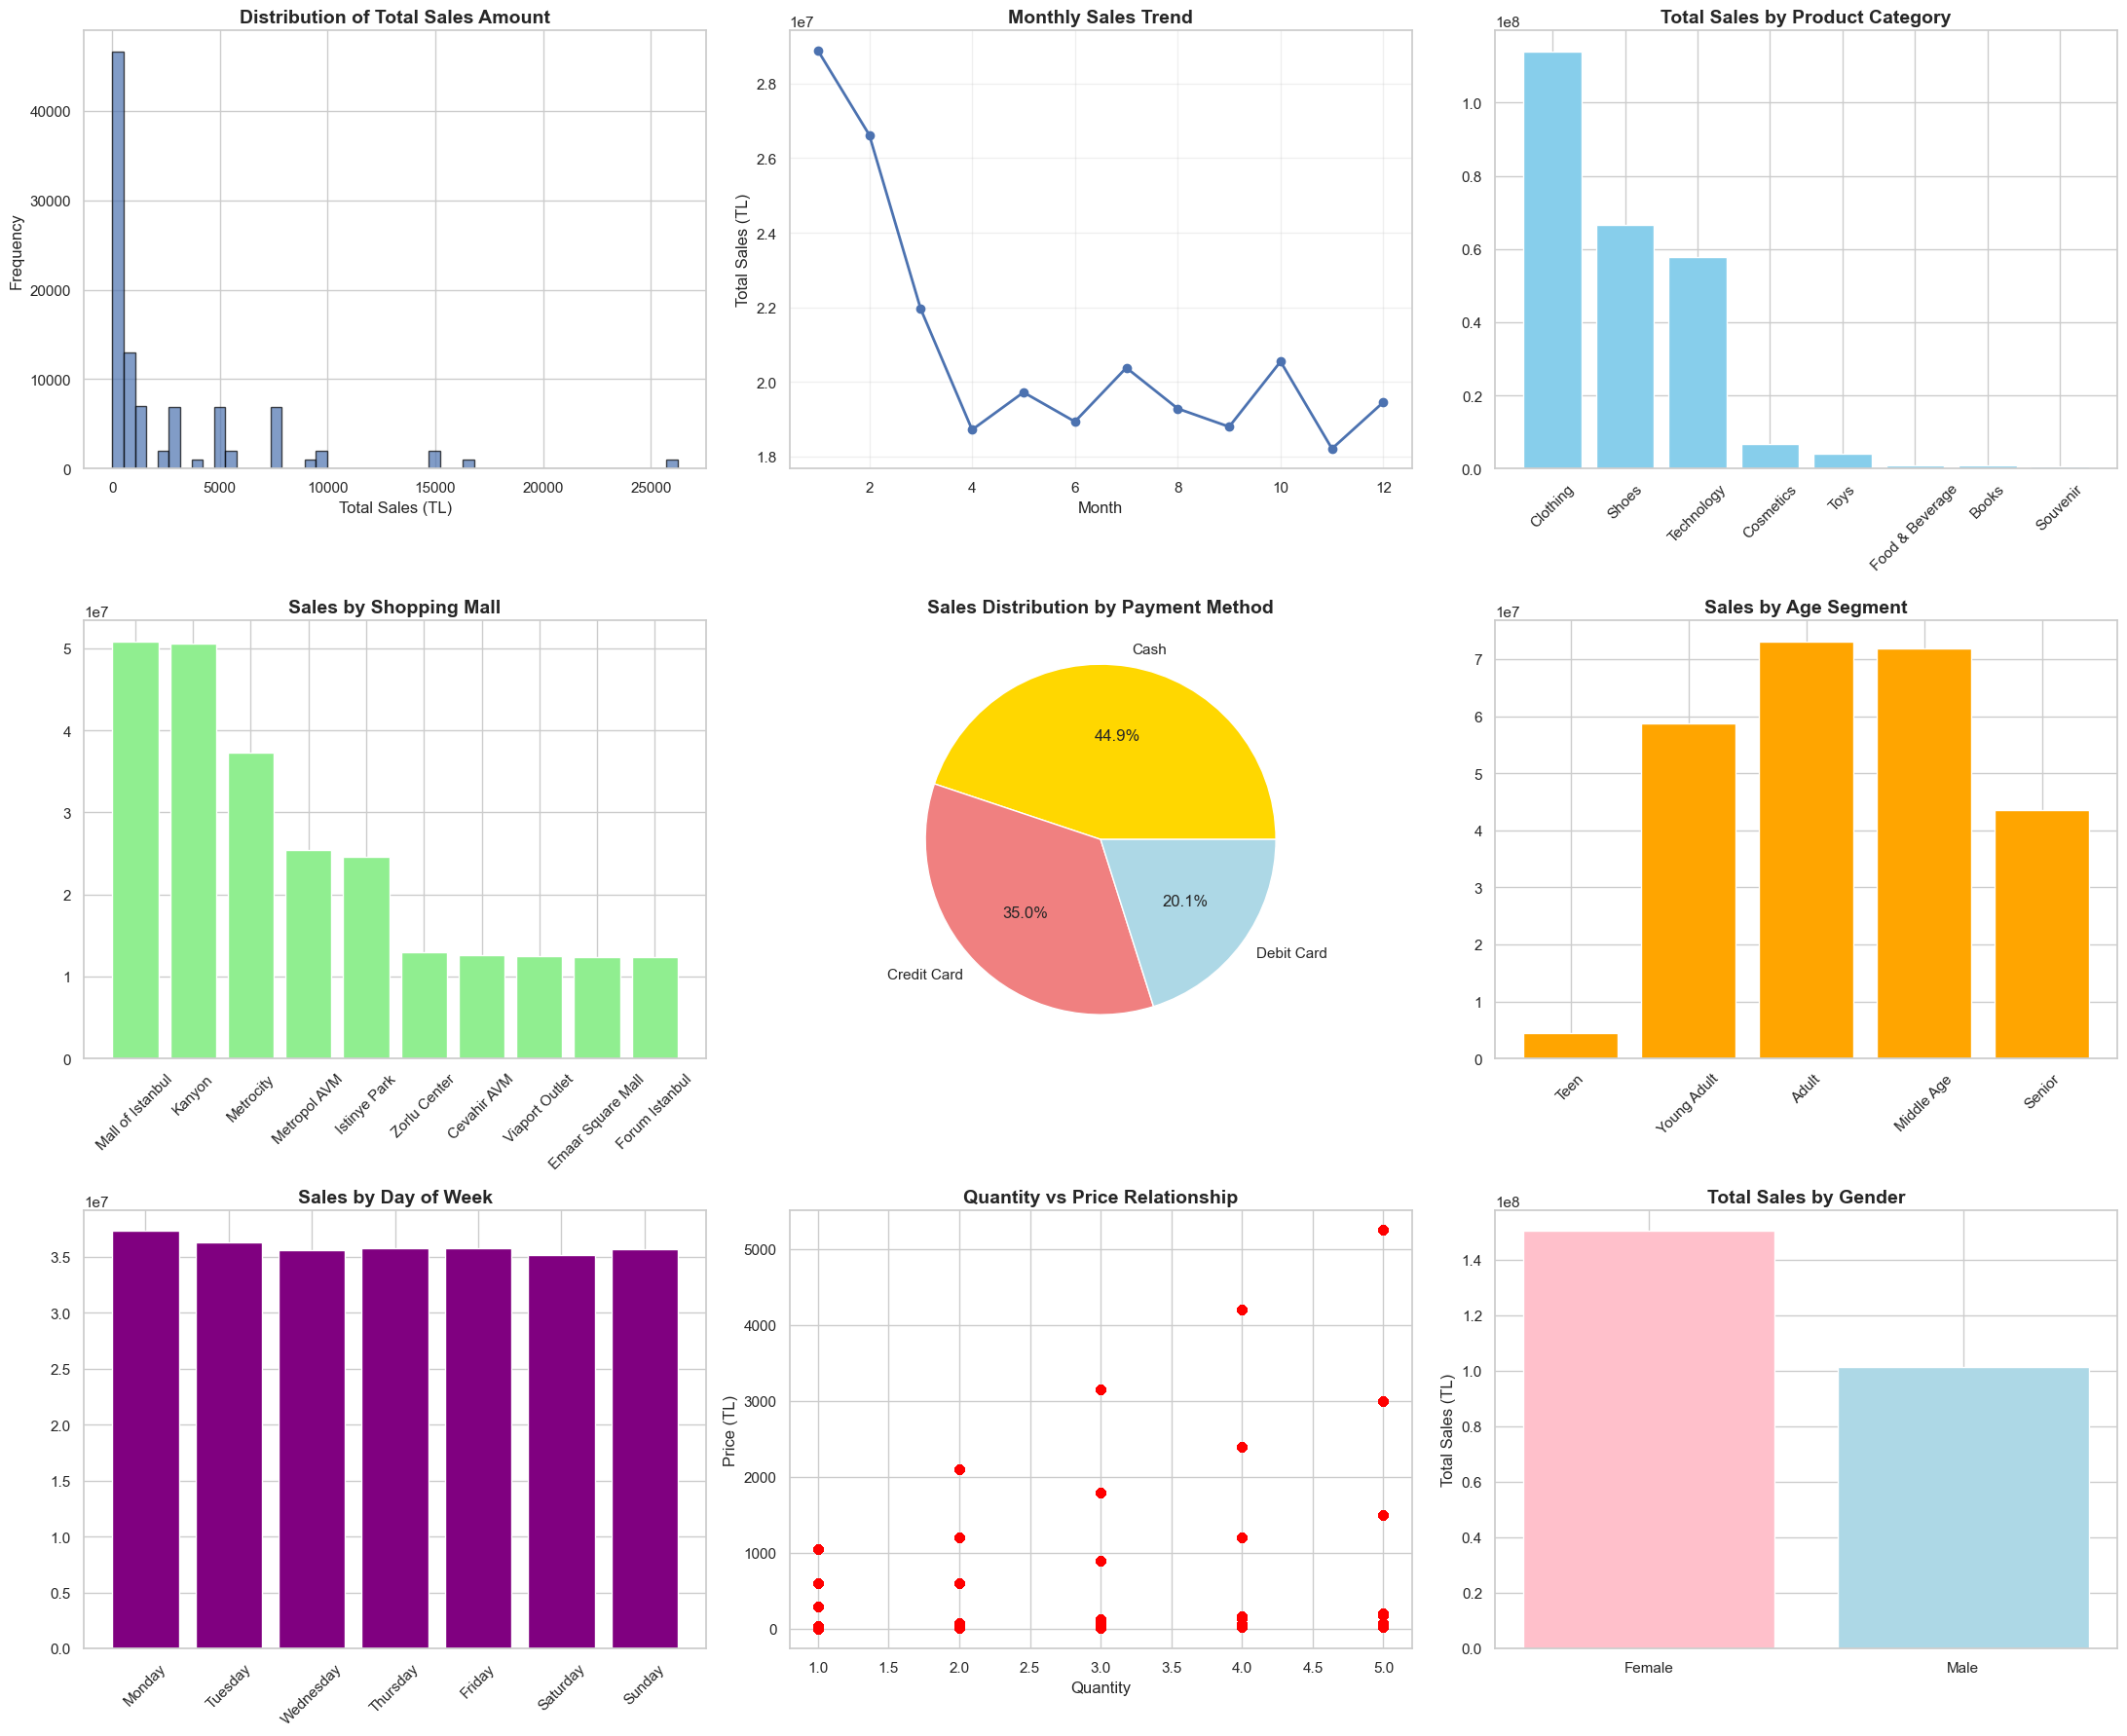

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(22, 18))

# 1. Total Sales Distribution
axes[0,0].hist(df_clean['total_sales'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribution of Total Sales Amount', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Total Sales (TL)')
axes[0,0].set_ylabel('Frequency')

# 2. Monthly Sales Trend
monthly_sales = df_clean.groupby('month')['total_sales'].sum()
axes[0,1].plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2)
axes[0,1].set_title('Monthly Sales Trend', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Total Sales (TL)')
axes[0,1].grid(True, alpha=0.3)

# 3. Sales by Product Category
category_sales = df_clean.groupby('category')['total_sales'].sum().sort_values(ascending=False)
axes[0,2].bar(category_sales.index, category_sales.values, color='skyblue')
axes[0,2].set_title('Total Sales by Product Category', fontsize=14, fontweight='bold')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Sales by Shopping Mall
mall_sales = df_clean.groupby('shopping_mall')['total_sales'].sum().sort_values(ascending=False)
axes[1,0].bar(mall_sales.index, mall_sales.values, color='lightgreen')
axes[1,0].set_title('Sales by Shopping Mall', fontsize=14, fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Sales by Payment Method
payment_sales = df_clean.groupby('payment_method')['total_sales'].sum()
axes[1,1].pie(
    payment_sales.values,
    labels=payment_sales.index,
    autopct='%1.1f%%',
    colors=['gold', 'lightcoral', 'lightblue']
)
axes[1,1].set_title('Sales Distribution by Payment Method', fontsize=14, fontweight='bold')

# 6. Sales by Age Segment
age_sales = df_clean.groupby('age_segment')['total_sales'].sum()
axes[1,2].bar(age_sales.index, age_sales.values, color='orange')
axes[1,2].set_title('Sales by Age Segment', fontsize=14, fontweight='bold')
axes[1,2].tick_params(axis='x', rotation=45)

# 7. Sales by Day of Week
daily_sales = df_clean.groupby('day_of_week')['total_sales'].sum()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
axes[2,0].bar(days, [daily_sales.get(day, 0) for day in days], color='purple')
axes[2,0].set_title('Sales by Day of Week', fontsize=14, fontweight='bold')
axes[2,0].tick_params(axis='x', rotation=45)

# 8. Quantity vs Price Scatter
axes[2,1].scatter(df_clean['quantity'], df_clean['price'], alpha=0.5, color='red')
axes[2,1].set_title('Quantity vs Price Relationship', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Quantity')
axes[2,1].set_ylabel('Price (TL)')

# 9. Gender-wise Sales Comparison
gender_sales = df_clean.groupby('gender')['total_sales'].sum()
axes[2,2].bar(gender_sales.index, gender_sales.values, color=['pink', 'lightblue'])
axes[2,2].set_title('Total Sales by Gender', fontsize=14, fontweight='bold')
axes[2,2].set_ylabel('Total Sales (TL)')

plt.tight_layout()
plt.show()

**TIME SERIES & SEASONAL PATTERNS**

Performing time series analysis...


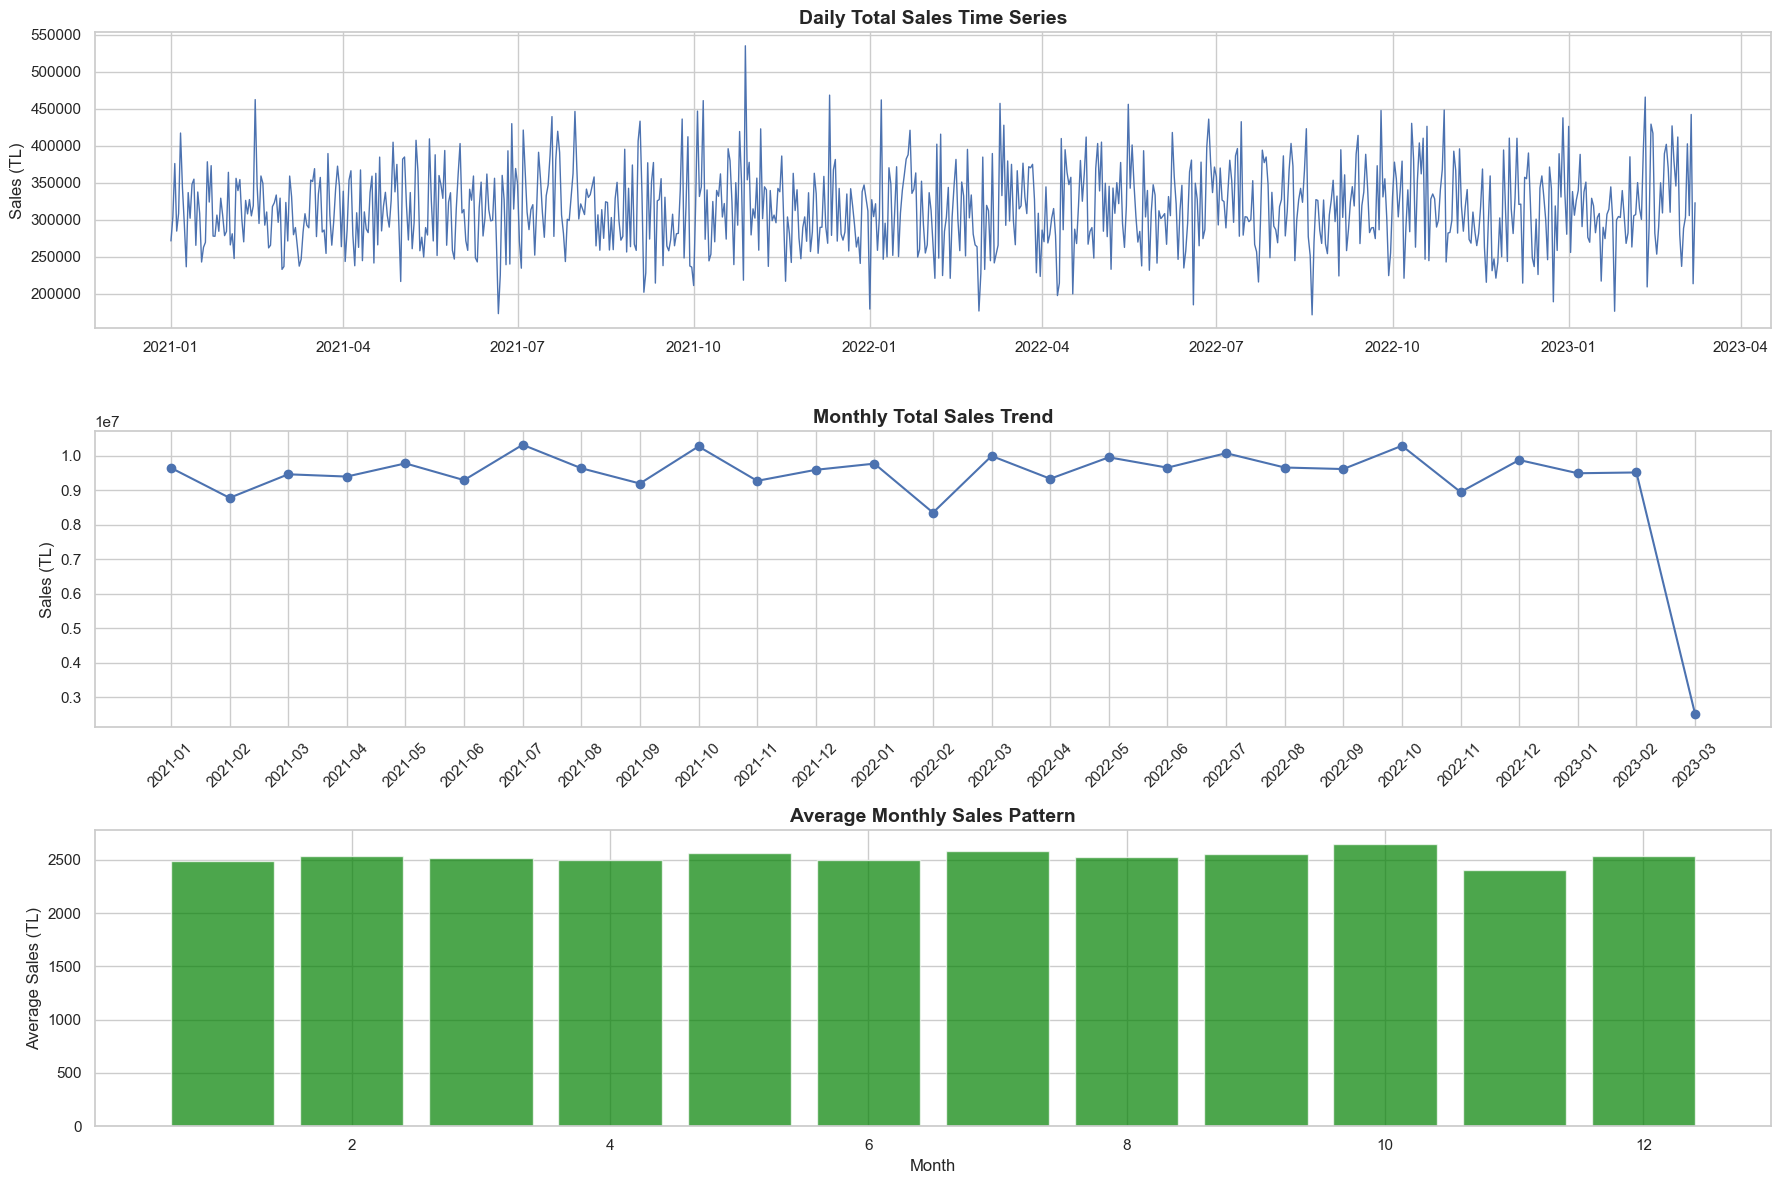

In [6]:
print("Performing time series analysis...")

daily_total_sales = df_clean.groupby('invoice_date')['total_sales'].sum()

plt.figure(figsize=(18, 12))

# 1. Daily Series
plt.subplot(3, 1, 1)
plt.plot(daily_total_sales.index, daily_total_sales.values, linewidth=1)
plt.title('Daily Total Sales Time Series', fontsize=14, fontweight='bold')
plt.ylabel('Sales (TL)')

# 2. Monthly Aggregate
monthly_total_sales = df_clean.groupby(df_clean['invoice_date'].dt.to_period('M'))['total_sales'].sum()
plt.subplot(3, 1, 2)
plt.plot(monthly_total_sales.index.astype(str), monthly_total_sales.values, marker='o')
plt.title('Monthly Total Sales Trend', fontsize=14, fontweight='bold')
plt.ylabel('Sales (TL)')
plt.xticks(rotation=45)

# 3. Seasonal Monthly Pattern
monthly_avg_sales = df_clean.groupby('month')['total_sales'].mean()
plt.subplot(3, 1, 3)
plt.bar(monthly_avg_sales.index, monthly_avg_sales.values, color='green', alpha=0.7)
plt.title('Average Monthly Sales Pattern', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Sales (TL)')

plt.tight_layout()
plt.show()


**Preparing ML pipeline**

In [7]:
# Creating transformers
numeric_transformer = Pipeline(steps=[
    ('scaling', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Splitting data
X = df[numeric_features + categorical_features]
y = df['total_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**PCA dimensionality reduction**

In [8]:
# Adding PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # keeping 95% variance

## **Building models**
1. **Random Forest Pipeline**

In [9]:
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', pca),
    ('model', RandomForestRegressor(random_state=42))
])


2. **XGBoost Pipeline**

In [10]:
xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', pca),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=300
    ))
])


## **Hyperparameter tuning**
**Random Forest tuning**

In [11]:
rf_params = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [6, 10],
    'model__min_samples_split': [2, 5],
    'model__max_features': ['sqrt']
}

rf_tuned = RandomizedSearchCV(
    rf_pipeline,
    rf_params,
    cv=2,
    n_iter=4,
    n_jobs=-1,
    verbose=1
)

rf_tuned.fit(X_train, y_train)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': [6, 10], 'model__max_features': ['sqrt'], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 150, ...]}"
,n_iter,4
,scoring,None
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


**XGBoost tuning**

In [21]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np # Import numpy for np.sqrt

# 1. Spliting a small validation set for early stopping (will be used to train the final model after tuning)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# 2. Using the already defined xgb_pipeline as the estimator


# 3. Fast hyperparameter search space for the pipeline's XGBoost model

xgb_params = {
    'model__max_depth': [4, 6],         # reduced
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1],
    'model__min_child_weight': [1, 3],
    'model__gamma': [0, 1],
    'model__n_estimators': [100, 150, 200] # Adding n_estimators to tune
}

# 4. Randomized Search (without early stopping during CV)
xgb_tuned = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_params,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_tuned.fit(
    X_tr, y_tr
)

# 5. Best estimator
best_xgb = xgb_tuned.best_estimator_
print("Best params:", xgb_tuned.best_params_)
# The best_score_ will be negative for 'neg_mean_squared_error', so negate it and take sqrt for RMSE.
print("Best CV RMSE:", np.sqrt(-xgb_tuned.best_score_))

# Retraining the best model with early stopping on X_train and X_val
print("\nRetraining best XGBoost model with early stopping...")

X_train_transformed = best_xgb.named_steps['preprocess'].transform(X_train)
X_train_transformed = best_xgb.named_steps['pca'].transform(X_train_transformed)

X_val_transformed = best_xgb.named_steps['preprocess'].transform(X_val)
X_val_transformed = best_xgb.named_steps['pca'].transform(X_val_transformed)

# Extracting best XGBoost model parameters from xgb_tuned.best_params_
best_xgb_model_params = {k.replace('model__', ''): v for k, v in xgb_tuned.best_params_.items()}

# Creating a new XGBoost Regressor with the best parameters
xgb_model_final = xgb.XGBRegressor(
    **best_xgb_model_params,
    objective='reg:squarederror',
    random_state=42 # Ensure reproducibility
)

# Fitting the new XGBoost model directly with the transformed data and early stopping parameters
xgb_model_final.fit(
    X_train_transformed, y_train,
    eval_set=[(X_val_transformed, y_val)]
)
print("Retraining complete.")

# Updating best_xgb to be the retrained model for subsequent evaluation and SHAP
best_xgb.named_steps['model'] = xgb_model_final

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'model__subsample': 1, 'model__n_estimators': 200, 'model__min_child_weight': 1, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__gamma': 0}
Best CV RMSE: 55.49829903478258

Retraining best XGBoost model with early stopping...
[0]	validation_0-rmse:3846.89689
[1]	validation_0-rmse:3462.85236
[2]	validation_0-rmse:3117.12688
[3]	validation_0-rmse:2805.93513
[4]	validation_0-rmse:2525.83656
[5]	validation_0-rmse:2273.69718
[6]	validation_0-rmse:2046.66582
[7]	validation_0-rmse:1842.31791
[8]	validation_0-rmse:1658.38269
[9]	validation_0-rmse:1492.68840
[10]	validation_0-rmse:1343.68586
[11]	validation_0-rmse:1209.43765
[12]	validation_0-rmse:1088.70727
[13]	validation_0-rmse:980.03689
[14]	validation_0-rmse:882.13210
[15]	validation_0-rmse:794.08549
[16]	validation_0-rmse:714.75337
[17]	validation_0-rmse:643.41348
[18]	validation_0-rmse:579.19368
[19]	validation_0-rmse:521.33726
[20]	validation_0-rmse:46

**Evaluation function**

In [13]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    return rmse, mae, r2, adj_r2


**Comparing model performance**

In [14]:
rf_scores = evaluate_model(rf_tuned, X_test, y_test)
xgb_scores = evaluate_model(xgb_tuned, X_test, y_test)

print("Random Forest:", rf_scores)
print("XGBoost:", xgb_scores)

Random Forest: (np.float64(76.77882561762327), 52.13785288190788, 0.9996781536582539, 0.9996779593750353)
XGBoost: (np.float64(37.790186958972065), 3.1784182237682206, 0.9999220306833233, 0.9999219836169819)


**SHAP Explainability (XGBoost recommended)**

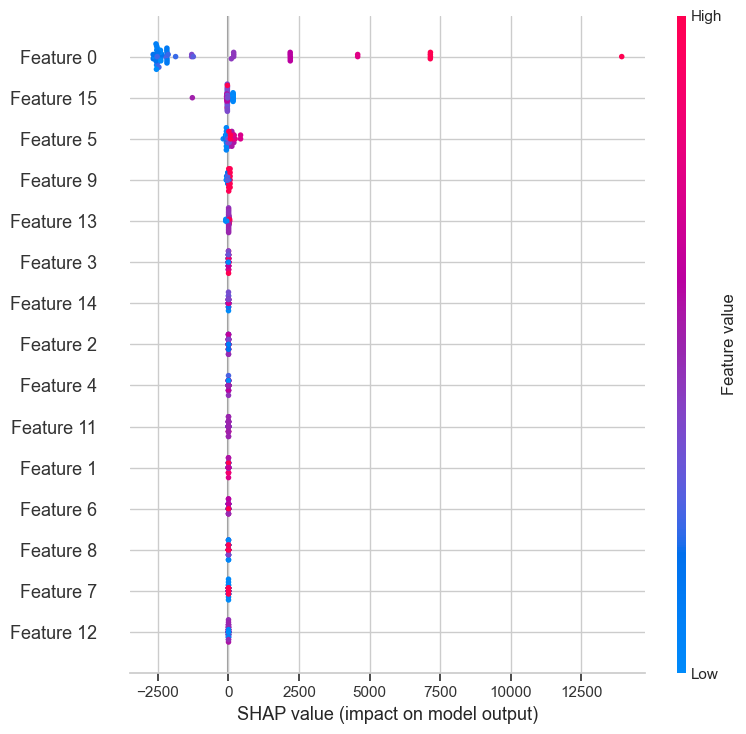

In [22]:
explainer = shap.TreeExplainer(
    xgb_tuned.best_estimator_['model'],
    feature_perturbation="tree_path_dependent",
    model_output="raw" 
)

X_small = X_test.sample(50, random_state=0)
# The preprocessor expects a DataFrame, so we transform X_small first
X_small_t_raw = xgb_tuned.best_estimator_['preprocess'].transform(X_small)

X_small_t = xgb_tuned.best_estimator_.named_steps['preprocess'].transform(X_small)
X_small_t = xgb_tuned.best_estimator_.named_steps['pca'].transform(X_small_t)

shap_values = explainer.shap_values(X_small_t)
shap.summary_plot(shap_values, X_small_t, max_display=15)


**MODEL PERFORMANCE COMPARISON**

In [27]:
print("--- Random Forest Model Metrics ---")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R²: {rf_r2:.4f}")
print(f"Adjusted R²: {rf_adj:.4f}")
print("\n--- XGBoost Model Metrics ---")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"R²: {xgb_r2:.4f}")
print(f"Adjusted R²: {xgb_adj:.4f}")

--- Random Forest Model Metrics ---
RMSE: 76.7788
MAE: 52.1379
R²: 0.9997
Adjusted R²: 0.9997

--- XGBoost Model Metrics ---
RMSE: 37.7902
MAE: 3.1784
R²: 0.9999
Adjusted R²: 0.9999


**Printing system architecture & pipeline diagrams**

In [24]:
from sklearn import set_config
set_config(display='diagram')

xgb_tuned.best_estimator_

,steps,"[('preprocess', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
y_pred_xgb = best_xgb.predict(X_test)

# Creating a DataFrame to display actual vs. predicted values
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_xgb
})

print("First 10 Actual vs. Predicted values from XGBoost model:")
display(predictions_df.head(10))

First 10 Actual vs. Predicted values from XGBoost model:


,Actual,Predicted
0,83.68,83.899185
1,130.75,133.850357
2,83.68,81.559914
3,130.75,131.126892
4,9602.72,9602.690430
5,896.00,895.225647
6,300.08,294.046387
7,242.40,244.286575
8,1200.32,1200.334717
9,9450.00,9450.093750


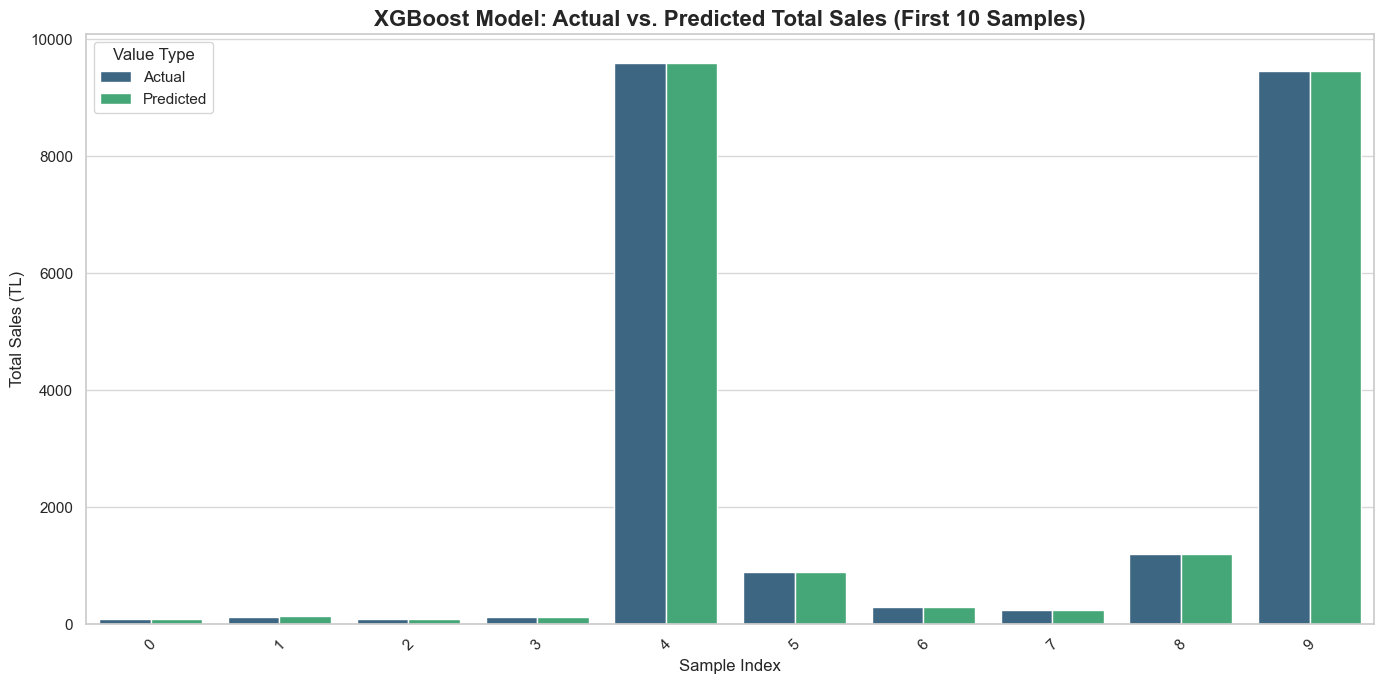

In [26]:
n_samples = 10 # Number of samples to display

# Get the first 'n_samples' from the predictions_df
subset_predictions_df = predictions_df.head(n_samples)

# Melt the DataFrame to prepare for seaborn bar plot
plot_df = subset_predictions_df.reset_index().melt(id_vars='index', var_name='Type', value_name='Total Sales')

plt.figure(figsize=(14, 7))
sns.barplot(x='index', y='Total Sales', hue='Type', data=plot_df, palette='viridis')
plt.title(f'XGBoost Model: Actual vs. Predicted Total Sales (First {n_samples} Samples)', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Total Sales (TL)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.legend(title='Value Type')
plt.tight_layout()
plt.show()

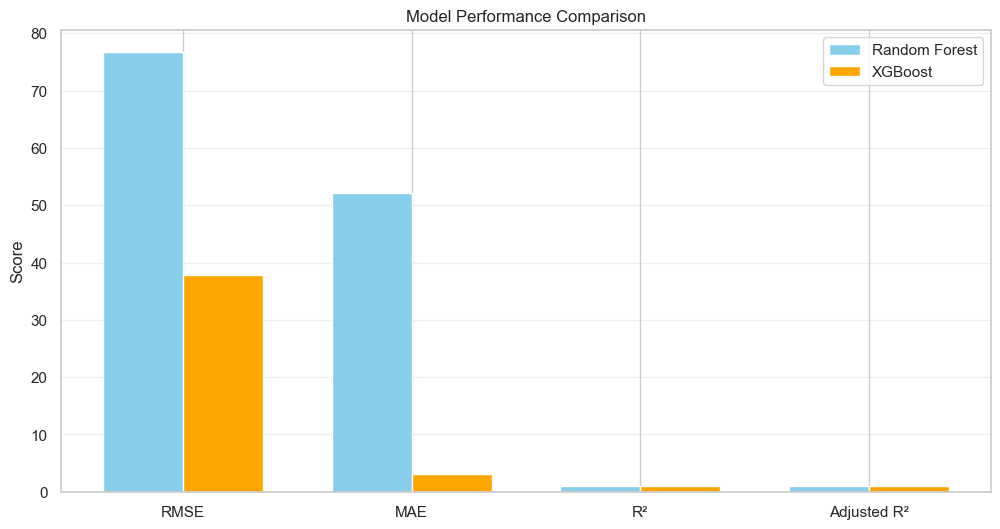

In [19]:
metrics = ['RMSE', 'MAE', 'R²', 'Adjusted R²']

# Unpack the scores from the tuples
rf_rmse, rf_mae, rf_r2, rf_adj = rf_scores
xgb_rmse, xgb_mae, xgb_r2, xgb_adj = xgb_scores

rf_values = [rf_rmse, rf_mae, rf_r2, rf_adj]
xgb_values = [xgb_rmse, xgb_mae, xgb_r2, xgb_adj]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, rf_values, width, label='Random Forest', color='skyblue')
plt.bar(x + width/2, xgb_values, width, label='XGBoost', color='orange')

plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

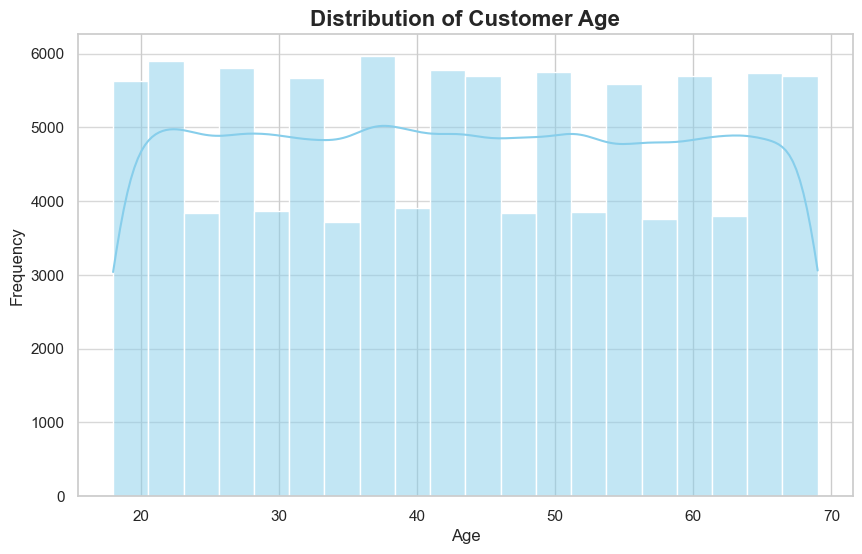

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Customer Age', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()